# A股数据分析

  **通过对A股数据可视化，通过沪深A股的行情数据和一些技术指标的观察研究，制定 选股策略（分类/预测/业务因子），通过算法预测走势，最后制定交易策略完成仿真回测研究**
  
 # 具体操作流程如下：
 
1. 数据获取
2. 预处理
3. 可视化观察
4. 选股
- 选取指标
- 特征提取
- 制定选股策略
- 完成选股

5. 预测走势
- 选取数据
- 预处理
- 多个预测算法尝试
- 评估算法效果
- 结果可视化

6、交易策略
- 历史+预测生成Baseline
- 制定选股策略
- 仿真回测
- 评估效果

7、场景应用

# 1、数据获取

使用  **baostock**
链接：http://baostock.com/baostock/index.php/Python_API%E6%96%87%E6%A1%A3

In [9]:
import baostock as bs
import pandas as pd
import os
import datetime



# 配置超参数
date_start='2000-01-01'   # 开始日期
date_end = datetime.datetime.now().strftime("%Y-%m-%d") # 结束日期
date_check_code = '2023-09-28'   # 获取股票code的日期
output_dir = './stockdata/'

# 获取数据字段（列名）
fields = "date,code,open,high,low,close,volume,amount," \
                      "adjustflag,turn,tradestatus,pctChg,peTTM," \
                      "pbMRQ,psTTM,pcfNcfTTM,isST"

In [ ]:
# 新建文件夹
def mkdir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print('success makedir')
mkdir(output_dir)

def get_codes_by_date( date):
    # 查询所有的股票代码
    stock_rs = bs.query_all_stock(date)
    stock_df = stock_rs.get_data()
    print(stock_df)
    return stock_df

# 连接服务
_bs = bs
bs.login()
stock_df = get_codes_by_date(date_check_code)

# 遍历查询每一个 code
for index, row in stock_df.iterrows():
    # 不要北京交易所的数据
    if 'bj' in row["code"]:
        continue
    print(f'processing {row["code"]} {row["code_name"]}')
    # 获取股票数据
    df_code = bs.query_history_k_data_plus(row["code"], fields,
                                           start_date=date_start,
                                           end_date=date_end).get_data()
    # 导出为 csv
    df_code.to_csv(f'{output_dir}/{row["code"]}.{row["code_name"]}.csv', index=False)

# 退出服务
bs.logout()

## 结果输出如下图
![jupyter](./1.png)

最后在本地生成文件夹：'./stockdata'
里面保存一个个下载的 csv文件

# 2、预处理

./stockdata2


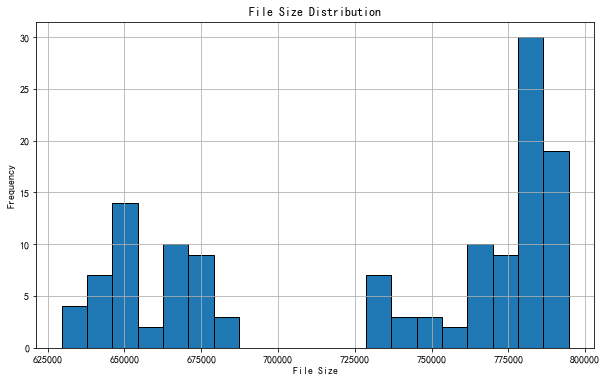

合并完成。


<Figure size 432x288 with 0 Axes>

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import threading
import glob



folder_path = './stockdata'
combined_csv_path = './combined.csv'

def get_size(folder_path):
    # 指定文件夹路径
    print(folder_path)
    folder_path = folder_path

    # 获取文件夹内所有文件的信息
    file_info = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            # 获取文件大小（以字节为单位）
            file_size_bytes = os.path.getsize(file_path)
            file_info.append({'Filename': filename, 'Size': file_size_bytes})

    # 将信息转换为DataFrame
    file_info_df = pd.DataFrame(file_info)
    file_info_df = file_info_df[file_info_df['Size'] >= 100]
    
    return file_info_df

def combine_csv(df,folder_path,combined_csv_path):
    # 列出要合并的CSV文件
    file_list = glob.glob(folder_path+'/*.csv')  
    
    # 创建一个空的DataFrame来存储合并后的数据
    combined_data = pd.DataFrame()

    # 遍历文件列表并逐个读取CSV文件并添加到combined_data中
    for file in file_list:
        if 'sh' in file and not any(substring in file for substring in ['上证','主题','指数']):
            # 只要上证，不然太大了
            df = pd.read_csv(file)
            combined_data = pd.concat([combined_data, df], ignore_index=True)

    # 将合并后的数据保存到一个新的CSV文件
    combined_data.to_csv(combined_csv_path, index=False)  # 将'合并后的文件.csv'替换为你想要保存的文件名
    print("合并完成。")


def plot_hist(df):
    # 按文件大小排序
    sorted_df = df.sort_values(by='Size', ascending=False)
    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.hist(sorted_df['Size'], bins=20, edgecolor='k')
    plt.title('File Size Distribution')
    plt.xlabel('File Size')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    plt.savefig('./File_size_distributing.png')



# 1、排除空文件
df = get_size(folder_path)
# 观察文件大小 画图,观察分布
plot_hist(df)
# 删除空的文文件:  rm ./bj.*
# 切割 code 及对应的 name
# df[['jy','code_num', 'name']] = df['Filename'].str.split('.', expand=True)[[0,1, 2]]
# df['code'] = df['jy'].astype(str) + '.' + df['code_num'].astype(str)
# 2、多线程合并成一个csv，便于读取
combine_csv(df,folder_path,combined_csv_path)

# 3、多个预测算法尝试
* 线性回归
* 多项式回归
* 岭回归
* Lasso回归

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima_model import ARIMA

# 线性回归
def linear_regression(X, y, X_test):
    model = LinearRegression()
    model.fit(X, y)
    prediction = model.predict(X_test)
    return prediction

# 多项式回归
def polynomial_regression(X, y, X_test, degree=2):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    X_test_poly = poly.transform(X_test)
    prediction = model.predict(X_test_poly)
    return prediction

# 岭回归
def ridge_regression(X, y, X_test, alpha=1.0):
    model = Ridge(alpha=alpha)
    model.fit(X, y)
    prediction = model.predict(X_test)
    return prediction

# Lasso回归
def lasso_regression(X, y, X_test, alpha=1.0):
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    prediction = model.predict(X_test)
    return prediction

(10726, 17)
linear_regression    MSE:327.8824, RMSE:10.3101, r2:-0.1028
polynomial_regression    MSE:335.2729, RMSE:10.4237, r2:-0.1276
ridge_regression    MSE:327.8824, RMSE:10.3101, r2:-0.1028
lasso_regression    MSE:306.9003, RMSE:15.3692, r2:-0.0322


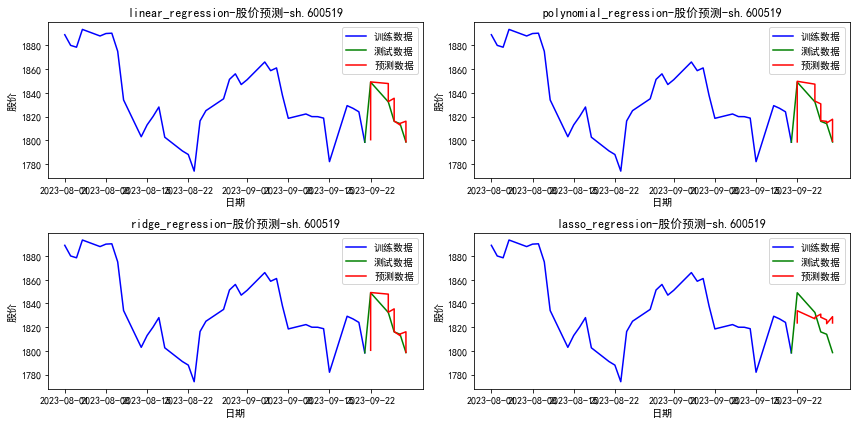

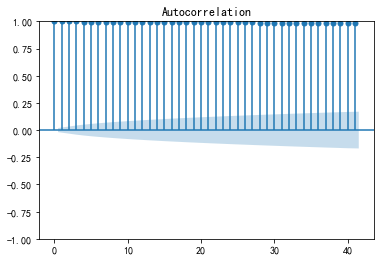

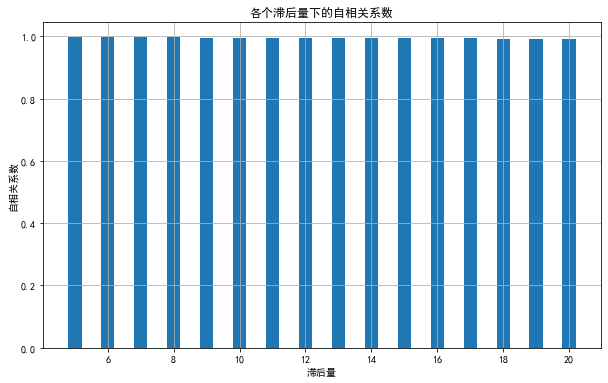

最大的自相关系数: 0.9980883560992043，对应的滞后量: 5


In [16]:
# -*- coding=utf8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error ,r2_score
# from re_model import linear_regression, polynomial_regression, ridge_regression, lasso_regression
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import warnings
warnings.filterwarnings("ignore")

class Single():
    def __init__(self):
        self.combined_csv_path = './combined.csv'
        self.plot_start_date = '2023-08-01'
        self.train_end_date='2023-08-01'

    def load_data(self,code='sh.688150'):
        df = pd.read_csv(self.combined_csv_path,
                         names=['date', 'code', 'open', 'high', 'low', 'close', 'volume', 'amount',
                                'adjustflag', 'turn', 'tradestatus', 'pctChg', 'peTTM',
                                'pbMRQ', 'psTTM', 'pcfNcfTTM', 'isST'])
        df['date'] = pd.to_datetime(df['date'])
        df = df[df['code']==code]
        df = df.sort_values(by='date',ascending=True)
        print(df.shape)
        #切割训练集和测试集（10天）
        self.train_end_date = df['date'].iloc[-11]
        test_begin_date = df['date'].iloc[-20]
        train_data = df[df['date'] < self.train_end_date]
        test_data = df[df['date'] >= test_begin_date]
        X_train, y_train = self.create_features_and_labels(train_data)
        X_test, y_test = self.create_features_and_labels(test_data)
        return  X_train,y_train,X_test,y_test,df

    # 提取特征和标签
    def create_features_and_labels(self,data):
        features = []
        labels = []
        for i in range(10, len(data)):
            features.append(data['close'].iloc[i - 10:i].values)
            labels.append(data['close'].iloc[i])
        return np.array(features), np.array(labels)

    def metrics_cl(self,y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_absolute_error(y_test, y_pred)
        r_S = r2_score(y_test, y_pred)
        return mse,rmse,r_S

    def plot_result(self,df,y_pred,model_name='',code=''):
        df = df[df['date'] >= self.plot_start_date]
        train_df =  df[df['date'] <= self.train_end_date]
        plt.plot(train_df['date'], train_df['close'], label='训练数据', color='blue')
        test_df = df[df['date'] >= self.train_end_date]
        pre_df = df[df['date'] > self.train_end_date]
        plt.plot(test_df['date'], test_df['close'], label='测试数据', color='green')
        plt.plot(pre_df['date'], y_pred, label='预测数据', color='red')
        plt.xlabel('日期')
        plt.ylabel('股价')
        plt.title(f'{model_name}-股价预测-{code}')
        plt.legend()
        # plt.show()


    def test_re_medel(self,X_train,y_train,X_test,y_test,df,code):
        plt.figure(figsize=(12, 6))
        # 线性回归
        y_pred = linear_regression(X_train,y_train,X_test)
        mse, rmse, r_S  = self.metrics_cl(y_test, y_pred)
        print(f"linear_regression    MSE:{mse:.4f}, RMSE:{rmse:.4f}, r2:{r_S:.4f}")
        plt.subplot(2, 2, 1)
        self.plot_result( df, y_pred,'linear_regression',code)
        # 多项式回归
        y_pred = polynomial_regression(X_train,y_train,X_test)
        mse, rmse, r_S  = self.metrics_cl(y_test, y_pred)
        print(f"polynomial_regression    MSE:{mse:.4f}, RMSE:{rmse:.4f}, r2:{r_S:.4f}")
        plt.subplot(2, 2, 2)
        self.plot_result(df, y_pred, 'polynomial_regression', code)
        # 岭回归
        plt.subplot(2, 2, 3)
        y_pred = ridge_regression(X_train,y_train,X_test)
        mse, rmse, r_S  = self.metrics_cl(y_test, y_pred)
        print(f"ridge_regression    MSE:{mse:.4f}, RMSE:{rmse:.4f}, r2:{r_S:.4f}")
        self.plot_result(df, y_pred, 'ridge_regression', code)
        # Lasso回归
        plt.subplot(2, 2, 4)
        y_pred = lasso_regression(X_train,y_train,X_test)
        mse, rmse, r_S  = self.metrics_cl(y_test, y_pred)
        print(f"lasso_regression    MSE:{mse:.4f}, RMSE:{rmse:.4f}, r2:{r_S:.4f}")
        self.plot_result(df, y_pred, 'lasso_regression', code)
        plt.tight_layout()
        plt.show()


    def time_sequence_test(self,df):
        df.set_index('date', inplace=True)
        # 1、先观察数据，画个图 绘制自相关函数图
        plot_acf(df['close'])
        plt.show()
        # 从自相关函数图中观察滞后值的相关性。通常，您可以看到自相关函数在某个滞后值后急剧下降。这表明在该滞后值之后，数据的相关性较低。

        # 计算自相关系数
        lags = range(5, 21)  # 滞后量范围

        acf_values = []
        for lag in lags:
            acf = sm.tsa.acf(df['close'], nlags=lag)
            acf_values.append(acf[lag])

        # 绘制自相关系数图
        plt.figure(figsize=(10, 6))
        plt.bar(lags, acf_values, width=0.4)
        plt.xlabel('滞后量')
        plt.ylabel('自相关系数')
        plt.title('各个滞后量下的自相关系数')
        plt.grid()
        plt.show()

        # 找出最大的自相关系数和对应的滞后量
        max_acf_value = max(acf_values)
        best_lag = lags[acf_values.index(max_acf_value)]
        print(f"最大的自相关系数: {max_acf_value}，对应的滞后量: {best_lag}")




    def run(self):
        code = 'sh.600519'
        X_train,y_train,X_test,y_test,df = self.load_data(code)
        # 测试四种回归算法
        self.test_re_medel(X_train,y_train,X_test,y_test,df,code)
        # 时间序列研究
        self.time_sequence_test(df)



if __name__ == '__main__':
    s = Single()
    s.run()

In [21]:
# 要检查的主字符串
main_string = "这是一个示例字符串"

# 字符串列表
string_list = ["Python", "编程", "字串"]

# 使用列表推导式检查是否包含
contains_substring = any(substring in main_string for substring in string_list)

# 判断是否包含
if contains_substring:
    print("主字符串包含列表中的某个字符串")
else:
    print("主字符串不包含列表中的任何字符串")

主字符串不包含列表中的任何字符串


In [20]:
any(substring in main_string for substring in string_list)

True